## Analyze a PR qualitatively

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
from numpy import save, load
import sqlalchemy as s
import unicodedata
import time
from sqlalchemy import create_engine

In [3]:
# Connection to local Postgres database

### Fetch features of PR for a repo_id
#### id, created_at, closed_at, state, title, body, commit_ids

In [ ]:
#repo_id = 27940

In [ ]:
  join_SQL = s.sql.text("""
  select repo_id, pull_requests.pull_request_id, pr_created_at, pr_src_title, pr_src_state, pr_closed_at, pr_merged_at, pull_request_commits.pr_cmt_id, pr_augur_contributor_id, pr_src_author_association, pr_html_url from augur_data.pull_requests
  INNER JOIN augur_data.pull_request_commits on pull_requests.pull_request_id = pull_request_commits.pull_request_id""")

# Transfer to Pandas df
df_pr = pd.read_sql_query(join_SQL, engine)

In [ ]:
df_pr['pull_request_id'].nunique()

107379

In [ ]:
df_pr = df_pr.drop_duplicates()

### Get count of commits associated with every PR

In [ ]:
df_pr['commit_counts'] = df_pr.groupby(['pull_request_id'])['pr_cmt_id'].transform('count')
df_pr = df_pr.drop(['pr_cmt_id'], axis=1)

In [ ]:
df_pr = df_pr.drop_duplicates()

In [ ]:
df_pr.shape

(107379, 11)

### Find length of PR in days

In [ ]:
df_pr['pr_length'] = (df_pr['pr_closed_at'] - df_pr['pr_created_at']).dt.days

In [ ]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107379 entries, 0 to 353138
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   repo_id                    107379 non-null  int64         
 1   pull_request_id            107379 non-null  int64         
 2   pr_created_at              107379 non-null  datetime64[ns]
 3   pr_src_title               107379 non-null  object        
 4   pr_src_state               107379 non-null  object        
 5   pr_closed_at               104079 non-null  datetime64[ns]
 6   pr_merged_at               72663 non-null   datetime64[ns]
 7   pr_augur_contributor_id    107378 non-null  float64       
 8   pr_src_author_association  107379 non-null  object        
 9   pr_html_url                107379 non-null  object        
 10  commit_counts              107379 non-null  int64         
 11  pr_length                  104079 non-null  float64 

### Get sentiment scores of title of PR

In [ ]:
import os

In [ ]:
os.path.exists('XGB_senti.pkl')

True

In [ ]:
!pip install emoji
import nltk
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from Sentiment import SentiCR
# Perform training or used trained model if exists. 
sentiment_analyzer = SentiCR(algo = 'XGB' )

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Using default train set
Reading data from oracle db..
Training classifier model..
Preprocessing done
Tfidf done
Training done


In [ ]:
# Function to get sentiment score
def get_senti_score(df,col,label=False):
    start_time = time.time()
    siz = df.shape[0]
    i = 0
    labels = []
    scores = []
    while (i<siz):
        if label:
            x, y = sentiment_analyzer.get_sentiment_polarity(df.iloc[i][col],label)
            labels.append(x)
            scores.append(y)
        else:
            score = sentiment_analyzer.get_sentiment_polarity(df.iloc[i][col],label)
            scores.append(score)
        i+=1
    scores = np.array(scores)
    labels = np.array(labels)
    if label:
        return (labels,scores)
    return scores

In [ ]:
df_pr['pr_title_senti'] = get_senti_score(df_pr,'pr_src_title')

In [ ]:
df_pr.groupby('pr_src_author_association').count()

,repo_id,pull_request_id,pr_created_at,pr_src_title,pr_src_state,pr_closed_at,pr_merged_at,pr_augur_contributor_id,pr_html_url,commit_counts,pr_length,pr_title_senti
pr_src_author_association,,,,,,,,,,,,
COLLABORATOR,4384,4384,4384,4384,4384,4317,3329,4384,4384,4384,4317,4384
CONTRIBUTOR,66649,66649,66649,66649,66649,65719,49584,66649,66649,66649,65719,66649
MEMBER,25053,25053,25053,25053,25053,24791,17168,25053,25053,25053,24791,25053
NONE,11293,11293,11293,11293,11293,9252,2582,11292,11293,11293,9252,11293


In [ ]:
df_pr = df_pr.drop(['pr_src_title'], axis=1)

In [ ]:
df_pr

,repo_id,pull_request_id,pr_created_at,pr_src_state,pr_closed_at,pr_merged_at,pr_augur_contributor_id,pr_src_author_association,pr_html_url,commit_counts,pr_length,pr_title_senti
0,25430,213958,2012-05-09 15:44:08,open,NaT,NaT,281589.0,NONE,https://github.com/rabbitmq/rmq-0mq/pull/5,3,NaN,0.0
3,25430,213960,2019-03-20 12:18:49,open,NaT,NaT,277209.0,NONE,https://github.com/rabbitmq/rmq-0mq/pull/8,1,NaN,0.0
4,25431,213441,2011-02-02 10:23:01,closed,2011-02-07 13:10:07,2011-02-07 13:10:07,277170.0,CONTRIBUTOR,https://github.com/rabbitmq/rabbitmq-c/pull/1,3,5.0,0.0
7,25431,259544,2013-09-27 09:51:25,closed,2013-09-28 03:25:11,NaT,306955.0,NONE,https://github.com/rabbitmq/rabbitmq-c/pull/12,250,0.0,0.0
224,25431,259548,2014-02-22 00:43:39,closed,2014-02-22 01:21:56,NaT,306953.0,NONE,https://github.com/rabbitmq/rabbitmq-c/pull/14,250,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
353079,25997,316553,2020-05-27 19:22:51,closed,2020-05-28 20:35:11,2020-05-28 20:35:11,287353.0,CONTRIBUTOR,https://github.com/SteeltoeOSS/Tooling/pull/101,43,1.0,0.0
353127,25857,316698,2020-05-27 18:59:19,open,NaT,NaT,383019.0,CONTRIBUTOR,https://github.com/greenplum-db/gpdb/pull/10193,2,NaN,0.0
353129,25857,316697,2020-05-27 18:39:42,open,NaT,NaT,277908.0,MEMBER,https://github.com/greenplum-db/gpdb/pull/10192,2,NaN,0.0
353131,25857,316702,2020-05-28 00:04:51,open,NaT,NaT,286946.0,CONTRIBUTOR,https://github.com/greenplum-db/gpdb/pull/10197,1,NaN,0.0


### Get average sentiment score of all messages relating to the PR

In [ ]:
'''join_SQL = s.sql.text("""
select message_analysis.msg_id, sentiment_score, message.cntrb_id, message.msg_text from augur_data.message_analysis
INNER JOIN augur_data.message on message_analysis.msg_id = message.msg_id""")

df_message = pd.read_sql_query(join_SQL, engine)'''


'join_SQL = s.sql.text("""\nselect message_analysis.msg_id, sentiment_score, message.cntrb_id, message.msg_text from augur_data.message_analysis\nINNER JOIN augur_data.message on message_analysis.msg_id = message.msg_id""")\n\ndf_message = pd.read_sql_query(join_SQL, engine)'

In [ ]:
# df_message = pd.read_csv(f'senti_repo_{repo_id}.csv')

join_SQL = s.sql.text("""
                select message.msg_id, msg_timestamp,  msg_text, message.cntrb_id from augur_data.message
                left outer join augur_data.pull_request_message_ref on message.msg_id = pull_request_message_ref.msg_id 
                left outer join augur_data.pull_requests on pull_request_message_ref.pull_request_id = pull_requests.pull_request_id
                UNION
                select message.msg_id, msg_timestamp, msg_text, message.cntrb_id from augur_data.message
                left outer join augur_data.issue_message_ref on message.msg_id = issue_message_ref.msg_id 
                left outer join augur_data.issues on issue_message_ref.issue_id = issues.issue_id""")
df_message = pd.read_sql_query(join_SQL, engine)

In [ ]:
df_message.head()

,msg_id,msg_timestamp,msg_text,cntrb_id
0,1810321,2018-07-17 06:28:21,Heikki Linnakangas spotted the mismatch compar...,286791.0
1,1749649,2019-02-04 15:07:14,@artembilan did you have time to review the ch...,289337.0
2,1781401,2018-08-07 21:44:40,@douglas-j-bothwell Thanks!,278082.0
3,1740003,2015-03-16 12:46:02,I just did.\n,289298.0
4,2089026,2018-04-02 09:36:36,Caused #5193 .,279457.0


In [ ]:
df_message['senti_score'] = get_senti_score(df_message,'msg_text')

In [ ]:
df_pr_ref = pd.read_sql_table('pull_request_message_ref',engine,schema='augur_data')

In [ ]:
df_pr_ref.head()

,pr_msg_ref_id,pull_request_id,msg_id,pr_message_ref_src_comment_id,pr_message_ref_src_node_id,tool_source,tool_version,data_source,data_collection_date
0,496935,209024,1691707,120855785,MDEyOklzc3VlQ29tbWVudDEyMDg1NTc4NQ==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-10 01:43:00
1,496936,209025,1691708,111075646,MDEyOklzc3VlQ29tbWVudDExMTA3NTY0Ng==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-10 01:43:02
2,496937,209025,1691709,119628549,MDEyOklzc3VlQ29tbWVudDExOTYyODU0OQ==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-10 01:43:02
3,496938,209026,1691710,122112698,MDEyOklzc3VlQ29tbWVudDEyMjExMjY5OA==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-10 01:43:03
4,496939,209026,1691711,122116101,MDEyOklzc3VlQ29tbWVudDEyMjExNjEwMQ==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-10 01:43:03


In [ ]:
df_merge = pd.merge(df_pr, df_pr_ref, on='pull_request_id',how='left')

In [ ]:
df_merge = pd.merge(df_merge, df_message, on='msg_id', how='left')
df_merge = df_merge.dropna(subset=['msg_id'], axis =0)

In [ ]:
df_merge['comment_counts'] = df_merge.groupby(['pull_request_id'])['msg_id'].transform('count')

In [ ]:
x=df_merge.head()

### Get participants count

In [ ]:
a = pd.DataFrame(df_merge.groupby(['pull_request_id'])['cntrb_id'].nunique())

In [ ]:
a = a.reset_index()
a = a.rename(columns={"cntrb_id": "usr_counts"})

In [ ]:
df_merge = pd.merge(df_merge, a, on='pull_request_id',how='left')

In [ ]:
df_merge

,repo_id,pull_request_id,pr_created_at,pr_src_state,pr_closed_at,pr_merged_at,pr_augur_contributor_id,pr_src_author_association,pr_html_url,commit_counts,pr_length,pr_title_senti,pr_msg_ref_id,msg_id,pr_message_ref_src_comment_id,pr_message_ref_src_node_id,tool_source,tool_version,data_source,data_collection_date,msg_timestamp,msg_text,cntrb_id,senti_score,comment_counts,usr_counts
0,25430,213958,2012-05-09 15:44:08,open,NaT,NaT,281589.0,NONE,https://github.com/rabbitmq/rmq-0mq/pull/5,3,NaN,0.0,503416.0,1703561.0,41147820.0,MDEyOklzc3VlQ29tbWVudDQxMTQ3ODIw,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-14 03:45:54,2014-04-23 10:52:58,Is this still being maintained? I see this iss...,309282.0,0.000000,3,2
1,25430,213958,2012-05-09 15:44:08,open,NaT,NaT,281589.0,NONE,https://github.com/rabbitmq/rmq-0mq/pull/5,3,NaN,0.0,503417.0,1703562.0,41150747.0,MDEyOklzc3VlQ29tbWVudDQxMTUwNzQ3,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-14 03:45:54,2014-04-23 11:37:09,"> Is this still being maintained?\n\nNo, I don...",277163.0,-0.526150,3,2
2,25430,213958,2012-05-09 15:44:08,open,NaT,NaT,281589.0,NONE,https://github.com/rabbitmq/rmq-0mq/pull/5,3,NaN,0.0,503418.0,1703563.0,41266568.0,MDEyOklzc3VlQ29tbWVudDQxMjY2NTY4,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-14 03:45:54,2014-04-24 10:48:24,That's too bad! Thanks for letting us know.\n,309282.0,0.878673,3,2
3,25431,213441,2011-02-02 10:23:01,closed,2011-02-07 13:10:07,2011-02-07 13:10:07,277170.0,CONTRIBUTOR,https://github.com/rabbitmq/rabbitmq-c/pull/1,3,5.0,0.0,502724.0,1702869.0,734502.0,MDEyOklzc3VlQ29tbWVudDczNDUwMg==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-13 19:43:38,2011-02-03 02:26:20,Wow. I'm _very_ surprised to see an implementa...,277167.0,-0.604481,6,3
4,25431,213441,2011-02-02 10:23:01,closed,2011-02-07 13:10:07,2011-02-07 13:10:07,277170.0,CONTRIBUTOR,https://github.com/rabbitmq/rabbitmq-c/pull/1,3,5.0,0.0,502725.0,1702870.0,735507.0,MDEyOklzc3VlQ29tbWVudDczNTUwNw==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-02-13 19:43:46,2011-02-03 11:59:38,I discussed this with David from RabbitMQ and ...,277170.0,0.000000,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172719,25857,316698,2020-05-27 18:59:19,open,NaT,NaT,383019.0,CONTRIBUTOR,https://github.com/greenplum-db/gpdb/pull/10193,2,NaN,0.0,670245.0,2119545.0,634874514.0,MDEyOklzc3VlQ29tbWVudDYzNDg3NDUxNA==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-05-28 10:19:47,2020-05-27 19:00:07,I am still running a dev pipeline (https://dev...,383019.0,0.000000,4,2
172720,25857,316698,2020-05-27 18:59:19,open,NaT,NaT,383019.0,CONTRIBUTOR,https://github.com/greenplum-db/gpdb/pull/10193,2,NaN,0.0,670246.0,2119546.0,634882032.0,MDEyOklzc3VlQ29tbWVudDYzNDg4MjAzMg==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-05-28 10:19:47,2020-05-27 19:14:43,@bradfordb-vmware Thank you for signing the [C...,278026.0,0.838446,4,2
172721,25857,316697,2020-05-27 18:39:42,open,NaT,NaT,277908.0,MEMBER,https://github.com/greenplum-db/gpdb/pull/10192,2,NaN,0.0,670241.0,2119541.0,634950835.0,MDEyOklzc3VlQ29tbWVudDYzNDk1MDgzNQ==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-05-28 10:19:44,2020-05-27 21:27:49,"Looks good to me, but I'll let other's with a ...",286784.0,0.701952,2,2
172722,25857,316697,2020-05-27 18:39:42,open,NaT,NaT,277908.0,MEMBER,https://github.com/greenplum-db/gpdb/pull/10192,2,NaN,0.0,670242.0,2119542.0,635179117.0,MDEyOklzc3VlQ29tbWVudDYzNTE3OTExNw==,GitHub Pull Request Worker,0.0.1,GitHub API,2020-05-28 10:19:44,2020-05-28 07:54:30,24 hours to 9 minutes is still insanely surpri...,284295.0,0.000000,2,2


In [ ]:
df_fin = df_merge[['pull_request_id','repo_id','pr_created_at','pr_closed_at','pr_merged_at','commit_counts','comment_counts','pr_length','pr_title_senti','senti_score', 'pr_augur_contributor_id', 'pr_src_author_association', 'usr_counts']]

In [ ]:
df_fin

,pull_request_id,repo_id,pr_created_at,pr_closed_at,pr_merged_at,commit_counts,comment_counts,pr_length,pr_title_senti,senti_score,pr_augur_contributor_id,pr_src_author_association,usr_counts
0,213958,25430,2012-05-09 15:44:08,NaT,NaT,3,3,NaN,0.0,0.000000,281589.0,NONE,2
1,213958,25430,2012-05-09 15:44:08,NaT,NaT,3,3,NaN,0.0,-0.526150,281589.0,NONE,2
2,213958,25430,2012-05-09 15:44:08,NaT,NaT,3,3,NaN,0.0,0.878673,281589.0,NONE,2
3,213441,25431,2011-02-02 10:23:01,2011-02-07 13:10:07,2011-02-07 13:10:07,3,6,5.0,0.0,-0.604481,277170.0,CONTRIBUTOR,3
4,213441,25431,2011-02-02 10:23:01,2011-02-07 13:10:07,2011-02-07 13:10:07,3,6,5.0,0.0,0.000000,277170.0,CONTRIBUTOR,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172719,316698,25857,2020-05-27 18:59:19,NaT,NaT,2,4,NaN,0.0,0.000000,383019.0,CONTRIBUTOR,2
172720,316698,25857,2020-05-27 18:59:19,NaT,NaT,2,4,NaN,0.0,0.838446,383019.0,CONTRIBUTOR,2
172721,316697,25857,2020-05-27 18:39:42,NaT,NaT,2,2,NaN,0.0,0.701952,277908.0,MEMBER,2
172722,316697,25857,2020-05-27 18:39:42,NaT,NaT,2,2,NaN,0.0,0.000000,277908.0,MEMBER,2


In [ ]:
df_fin['comment_senti_score'] = df_fin.groupby(['pull_request_id'])['senti_score'].transform('mean')

In [ ]:
df_fin = df_fin.drop(['senti_score'], axis=1)

In [ ]:
df_fin

,pull_request_id,repo_id,pr_created_at,pr_closed_at,pr_merged_at,commit_counts,comment_counts,pr_length,pr_title_senti,pr_augur_contributor_id,pr_src_author_association,usr_counts,comment_senti_score
0,213958,25430,2012-05-09 15:44:08,NaT,NaT,3,3,NaN,0.0,281589.0,NONE,2,0.117508
1,213958,25430,2012-05-09 15:44:08,NaT,NaT,3,3,NaN,0.0,281589.0,NONE,2,0.117508
2,213958,25430,2012-05-09 15:44:08,NaT,NaT,3,3,NaN,0.0,281589.0,NONE,2,0.117508
3,213441,25431,2011-02-02 10:23:01,2011-02-07 13:10:07,2011-02-07 13:10:07,3,6,5.0,0.0,277170.0,CONTRIBUTOR,3,-0.165998
4,213441,25431,2011-02-02 10:23:01,2011-02-07 13:10:07,2011-02-07 13:10:07,3,6,5.0,0.0,277170.0,CONTRIBUTOR,3,-0.165998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172719,316698,25857,2020-05-27 18:59:19,NaT,NaT,2,4,NaN,0.0,383019.0,CONTRIBUTOR,2,0.209612
172720,316698,25857,2020-05-27 18:59:19,NaT,NaT,2,4,NaN,0.0,383019.0,CONTRIBUTOR,2,0.209612
172721,316697,25857,2020-05-27 18:39:42,NaT,NaT,2,2,NaN,0.0,277908.0,MEMBER,2,0.350976
172722,316697,25857,2020-05-27 18:39:42,NaT,NaT,2,2,NaN,0.0,277908.0,MEMBER,2,0.350976


In [ ]:
df_fin = df_fin.drop_duplicates()

In [ ]:
df_fin['pull_request_id'].nunique()

64059



```
# This is formatted as code
```

### Get cntrb info from API

In [10]:
sql = 'SELECT cntrb_id, gh_login FROM augur_data.contributors'
df_ctrb = pd.read_sql_query(sql, engine)

In [11]:
df_ctrb

,cntrb_id,gh_login
0,1,nobody
1,277109,dependabot-preview[bot]
2,277110,9numbernine9
3,277111,KeenanHoffman
4,277112,BooleanCat
...,...,...
98553,384797,madcatter24
98554,384798,madcatter24
98555,384799,madcatter24
98556,384800,NotTheEconomist


In [ ]:
df_fin1 = pd.merge(df_fin,df_ctrb,left_on='pr_augur_contributor_id', right_on='cntrb_id', how='left')

In [ ]:
df_fin1 = df_fin1.drop(['cntrb_id'],axis=1)

In [ ]:
user_info = {}

In [ ]:
import requests
def fetch_user_info(uname):
    print(uname)
    if uname in user_info:
        return user_info[uname]['merged']/user_info[uname]['total']
    
    url = f"https://api.github.com/search/issues?q=is:pr+author:{uname}+is:merged"
    # make the request and return the json
    user_data = requests.get(url).json()
    merged = user_data['total_count']
    
    url = f"https://api.github.com/search/issues?q=is:pr+author:{uname}"
    # make the request and return the json
    user_data = requests.get(url).json()
    total = user_data['total_count']
    
    user_info['uname'] = {"merged": merged, "total": total}
    return merged/total

In [ ]:
df_fin1['usr_past_pr_accept'] = df_fin1['gh_login'].apply(fetch_user_info)

In [ ]:
df_fin1.to_csv('pr_disc.csv',index=False)

In [13]:
df_fin1 = pd.read_csv("pr_disc.csv")

In [14]:
df_fin1

,pull_request_id,repo_id,pr_created_at,pr_closed_at,pr_merged_at,commit_counts,comment_counts,pr_length,pr_title_senti,pr_augur_contributor_id,pr_src_author_association,usr_counts,comment_senti_score,gh_login
0,213958,25430,2012-05-09 15:44:08,NaN,NaN,3,3,NaN,0.0,281589.0,NONE,2,0.117508,lrascao
1,213441,25431,2011-02-02 10:23:01,2011-02-07 13:10:07,2011-02-07 13:10:07,3,6,5.0,0.0,277170.0,CONTRIBUTOR,3,-0.165998,mrtazz
2,259544,25431,2013-09-27 09:51:25,2013-09-28 03:25:11,NaN,250,1,0.0,0.0,306955.0,NONE,1,0.000000,dubrsl
3,259555,25431,2017-08-11 08:24:52,2017-08-11 15:30:44,NaN,250,1,0.0,0.0,306952.0,NONE,1,0.000000,SunilRN
4,259559,25431,2017-12-17 17:36:19,2017-12-17 17:41:28,NaN,250,2,0.0,0.0,306951.0,NONE,2,0.000000,pduveau
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64054,316683,25703,2020-05-27 17:21:15,2020-05-27 17:39:56,2020-05-27 17:39:56,1,1,0.0,0.0,285937.0,MEMBER,1,0.000000,artembilan
64055,316699,25857,2020-05-27 21:19:02,2020-05-27 23:39:50,2020-05-27 23:39:50,2,3,0.0,0.0,284294.0,MEMBER,3,0.000000,hardikar
64056,316698,25857,2020-05-27 18:59:19,NaN,NaN,2,4,NaN,0.0,383019.0,CONTRIBUTOR,2,0.209612,bradfordb-vmware
64057,316697,25857,2020-05-27 18:39:42,NaN,NaN,2,2,NaN,0.0,277908.0,MEMBER,2,0.350976,jchampio


*italicized text*### Get repo info

In [123]:
sql = 'SELECT repo_id, pull_requests_merged, pull_request_count,watchers_count,open_issues, last_updated FROM augur_data.repo_info'
df_repo = pd.read_sql_query(sql, engine)

In [124]:
df_repo

,repo_id,pull_requests_merged,pull_request_count,watchers_count,open_issues,last_updated
0,25430,1,3,25,0,2020-01-25 03:25:37
1,25431,2,14,21,2,2020-01-16 03:26:59
2,25432,872,1060,376,69,2020-02-09 17:23:44
3,25433,8,10,20,0,2020-01-04 00:18:27
4,25434,0,2,11,0,2019-03-14 09:54:40
...,...,...,...,...,...,...
91090,26236,0,0,2,0,2016-04-25 14:11:40
91091,26237,0,0,2,0,2016-04-25 15:23:06
91092,26238,0,0,2,0,2016-06-30 18:15:01
91093,26239,0,0,2,0,2016-08-18 18:54:26


In [125]:
df_repo['repo_id'].nunique()

3042

In [126]:
df_repo = df_repo.loc[df_repo.groupby('repo_id').last_updated.idxmax(),:]
df_repo = df_repo.drop(['last_updated'],axis=1)

In [127]:
df = pd.merge(df_fin1,df_repo,on='repo_id',how='left')

In [15]:
df=df_fin1
df=df.drop_duplicates()

In [128]:
df = df[df['pr_closed_at'].notna()]

In [17]:
df

,pull_request_id,repo_id,pr_created_at,pr_closed_at,pr_merged_at,commit_counts,comment_counts,pr_length,pr_title_senti,pr_augur_contributor_id,pr_src_author_association,usr_counts,comment_senti_score,gh_login
1,213441,25431,2011-02-02 10:23:01,2011-02-07 13:10:07,2011-02-07 13:10:07,3,6,5.0,0.0,277170.0,CONTRIBUTOR,3,-0.165998,mrtazz
2,259544,25431,2013-09-27 09:51:25,2013-09-28 03:25:11,NaN,250,1,0.0,0.0,306955.0,NONE,1,0.000000,dubrsl
3,259555,25431,2017-08-11 08:24:52,2017-08-11 15:30:44,NaN,250,1,0.0,0.0,306952.0,NONE,1,0.000000,SunilRN
4,259559,25431,2017-12-17 17:36:19,2017-12-17 17:41:28,NaN,250,2,0.0,0.0,306951.0,NONE,2,0.000000,pduveau
5,214543,25432,2015-10-21 15:51:13,2015-11-18 12:49:27,2015-11-18 12:49:27,36,1,27.0,0.0,277349.0,MEMBER,1,0.000000,videlalvaro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64048,316668,25522,2020-05-27 02:16:58,2020-05-27 07:20:55,2020-05-27 07:20:55,1,3,0.0,0.0,384057.0,CONTRIBUTOR,2,0.591519,steven-wan
64050,316648,25650,2020-05-27 06:11:07,2020-05-27 07:34:29,NaN,1,1,0.0,0.0,279196.0,CONTRIBUTOR,1,0.932668,mhyeon-lee
64052,316680,25663,2020-05-27 02:30:57,2020-05-27 14:32:34,NaN,1,3,0.0,0.0,384071.0,CONTRIBUTOR,2,0.555030,limo520
64054,316683,25703,2020-05-27 17:21:15,2020-05-27 17:39:56,2020-05-27 17:39:56,1,1,0.0,0.0,285937.0,MEMBER,1,0.000000,artembilan


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62752 entries, 1 to 64055
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pull_request_id            62752 non-null  int64  
 1   repo_id                    62752 non-null  int64  
 2   pr_created_at              62752 non-null  object 
 3   pr_closed_at               62752 non-null  object 
 4   pr_merged_at               37811 non-null  object 
 5   commit_counts              62752 non-null  int64  
 6   comment_counts             62752 non-null  int64  
 7   pr_length                  62752 non-null  float64
 8   pr_title_senti             62752 non-null  float64
 9   pr_augur_contributor_id    62752 non-null  float64
 10  pr_src_author_association  62752 non-null  object 
 11  usr_counts                 62752 non-null  int64  
 12  comment_senti_score        62752 non-null  float64
 13  gh_login                   62501 non-null  obj

In [130]:
df['accepted'] = df.apply(lambda x: 0 if pd.isnull(x['pr_merged_at']) else 1, axis=1)

In [ ]:
df.to_csv('Full_PR.csv',index=False)

In [8]:
df = pd.read_csv('Full_PR.csv')

In [131]:
df = df.drop(['pr_created_at','pr_closed_at','pr_merged_at','gh_login','gh_login','pr_augur_contributor_id'],axis=1)

In [137]:
df

,pull_request_id,repo_id,commit_counts,comment_counts,pr_length,pr_title_senti,pr_src_author_association,usr_counts,comment_senti_score,watchers_count,accepted,pr_accept_ratio
1,213441,25431,3,6,5.0,0.0,CONTRIBUTOR,3,-0.165998,20,1,0.133333
2,259544,25431,250,1,0.0,0.0,NONE,1,0.000000,20,0,0.133333
3,259555,25431,250,1,0.0,0.0,NONE,1,0.000000,20,0,0.133333
4,259559,25431,250,2,0.0,0.0,NONE,2,0.000000,20,0,0.133333
5,214543,25432,36,1,27.0,0.0,MEMBER,1,0.000000,381,1,0.830973
...,...,...,...,...,...,...,...,...,...,...,...,...
64048,316668,25522,1,3,0.0,0.0,CONTRIBUTOR,2,0.591519,43,1,0.848118
64050,316648,25650,1,1,0.0,0.0,CONTRIBUTOR,1,0.932668,99,0,0.090703
64052,316680,25663,1,3,0.0,0.0,CONTRIBUTOR,2,0.555030,3456,0,0.189347
64054,316683,25703,1,1,0.0,0.0,MEMBER,1,0.000000,114,1,0.363976


In [133]:
df['pr_accept_ratio'] =  df['pull_requests_merged']/df['pull_request_count']

In [134]:
df = df.drop(['pull_requests_merged','pull_request_count'],axis=1)

In [136]:
df = df.drop(['open_issues'],axis=1)

In [138]:
def encoder(x):
  if x=='NONE':
    return 0
  if x=='CONTRIBUTOR':
    return 1
  if x=='COLLABORATOR':
    return 2
  if x=='MEMBER':
    return 3

In [139]:
df['assc_level'] = df['pr_src_author_association'].apply(encoder)

In [140]:
df = df.drop(['pr_src_author_association'], axis=1)
df

,pull_request_id,repo_id,commit_counts,comment_counts,pr_length,pr_title_senti,usr_counts,comment_senti_score,watchers_count,accepted,pr_accept_ratio,assc_level
1,213441,25431,3,6,5.0,0.0,3,-0.165998,20,1,0.133333,1
2,259544,25431,250,1,0.0,0.0,1,0.000000,20,0,0.133333,0
3,259555,25431,250,1,0.0,0.0,1,0.000000,20,0,0.133333,0
4,259559,25431,250,2,0.0,0.0,2,0.000000,20,0,0.133333,0
5,214543,25432,36,1,27.0,0.0,1,0.000000,381,1,0.830973,3
...,...,...,...,...,...,...,...,...,...,...,...,...
64048,316668,25522,1,3,0.0,0.0,2,0.591519,43,1,0.848118,1
64050,316648,25650,1,1,0.0,0.0,1,0.932668,99,0,0.090703,1
64052,316680,25663,1,3,0.0,0.0,2,0.555030,3456,0,0.189347,1
64054,316683,25703,1,1,0.0,0.0,1,0.000000,114,1,0.363976,3


## Start XGB

In [141]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [143]:
features= df[['commit_counts','comment_counts','pr_length','assc_level','usr_counts','comment_senti_score','watchers_count','pr_accept_ratio']]
features

,commit_counts,comment_counts,pr_length,assc_level,usr_counts,comment_senti_score,watchers_count,pr_accept_ratio
1,3,6,5.0,1,3,-0.165998,20,0.133333
2,250,1,0.0,0,1,0.000000,20,0.133333
3,250,1,0.0,0,1,0.000000,20,0.133333
4,250,2,0.0,0,2,0.000000,20,0.133333
5,36,1,27.0,3,1,0.000000,381,0.830973
...,...,...,...,...,...,...,...,...
64048,1,3,0.0,1,2,0.591519,43,0.848118
64050,1,1,0.0,1,1,0.932668,99,0.090703
64052,1,3,0.0,1,2,0.555030,3456,0.189347
64054,1,1,0.0,3,1,0.000000,114,0.363976


In [166]:
features

,commit_counts,comment_counts,pr_length,assc_level,comment_senti_score,watchers_count,pr_accept_ratio
1,3,6,5.0,1,-0.165998,20,0.133333
2,250,1,0.0,0,0.000000,20,0.133333
3,250,1,0.0,0,0.000000,20,0.133333
4,250,2,0.0,0,0.000000,20,0.133333
5,36,1,27.0,3,0.000000,381,0.830973
...,...,...,...,...,...,...,...
64048,1,3,0.0,1,0.591519,43,0.848118
64050,1,1,0.0,1,0.932668,99,0.090703
64052,1,3,0.0,1,0.555030,3456,0.189347
64054,1,1,0.0,3,0.000000,114,0.363976


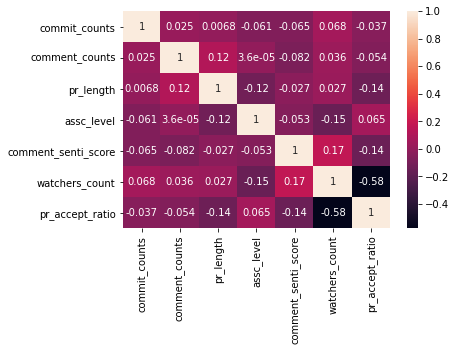

In [146]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = features.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


In [145]:
features = features.drop(['usr_counts'],axis=1)

In [147]:
y=df['accepted']

In [148]:
seed=5
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3,random_state=seed)

In [44]:
'''knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))'''

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 67.65
Time consumed for training: 0.405 seconds
Time consumed for prediction: 1.12245 seconds


In [83]:
'''rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))'''


Scikit-Learn's Random Forest Classifier's prediction accuracy is: 69.36
Time consumed for training: 0.396 seconds
Time consumed for prediction: 0.04517 seconds


In [38]:
'''from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
df_scaled = scaler_gnb.fit_transform(features)
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(df_scaled,y, test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))'''

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 63.67
Time consumed for training: 0.013 seconds
Time consumed for prediction: 0.00428 seconds


In [149]:
xgb = XGBClassifier(n_estimators=1000)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 84.91
Time consumed for training: 17.073
Time consumed for prediction: 0.60573 seconds


In [151]:
from sklearn.metrics import classification_report

print('naive Model XGboost Report:')
print(classification_report(y_test, preds))

naive Model XGboost Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      7485
           1       0.85      0.91      0.88     11341

    accuracy                           0.85     18826
   macro avg       0.85      0.83      0.84     18826
weighted avg       0.85      0.85      0.85     18826



In [152]:
importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
pr_accept_ratio,0.497632
assc_level,0.268371
pr_length,0.084050
comment_senti_score,0.048885
watchers_count,0.046324
commit_counts,0.033750
comment_counts,0.020988


In [153]:
xgb_cv = XGBClassifier(n_estimators=1000)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.8381516  0.83724107 0.8518097  0.85158206 0.84361484 0.8381516
 0.84813297 0.84744991 0.85769581 0.86065574]
Mean: 0.8474485302623773
Standard Deviation: 0.007795938418522512


In [154]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time xgb.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.86845	validation_0-error:0.167304	validation_1-auc:0.864993	validation_1-error:0.17035
[1]	validation_0-auc:0.883682	validation_0-error:0.167054	validation_1-auc:0.880182	validation_1-error:0.17019
[2]	validation_0-auc:0.884265	validation_0-error:0.166985	validation_1-auc:0.880877	validation_1-error:0.170031
[3]	validation_0-auc:0.885031	validation_0-error:0.166712	validation_1-auc:0.881539	validation_1-error:0.169871
[4]	validation_0-auc:0.886617	validation_0-error:0.172654	validation_1-auc:0.883665	validation_1-error:0.175768
[5]	validation_0-auc:0.886356	validation_0-error:0.16801	validation_1-auc:0.882856	validation_1-error:0.170881
[6]	validation_0-auc:0.885809	validation_0-error:0.165938	validation_1-auc:0.882327	validation_1-error:0.169871
[7]	validation_0-auc:0.886995	validation_0-error:0.165551	validation_1-auc:0.883877	validation_1-error:0.169606
[8]	validation_0-auc:0.889379	validation_0-error:0.166462	validation_1-auc:0.887018	validation_1-error:0.170

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_test = {
 'max_depth':[3,4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=970, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

train_model1 = gsearch.fit(X_train, y_train)
pred1 = train_model1.predict(X_test)
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred1) * 100))

Accuracy for model: 85.22


In [158]:
print(gsearch.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=970, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)


In [159]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      7485
           1       0.85      0.91      0.88     11341

    accuracy                           0.85     18826
   macro avg       0.85      0.84      0.84     18826
weighted avg       0.85      0.85      0.85     18826



In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_test = {
 'learning_rate':[0.01, 0.03, 0.05, 0.07, 0.1],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=970, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

train_model2 = gsearch2.fit(X_train, y_train)
pred2 = train_model2.predict(X_test)
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred2) * 100))

Accuracy for model: 85.04


In [161]:
print(gsearch2.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.07, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=970, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)


In [162]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      7485
           1       0.85      0.91      0.88     11341

    accuracy                           0.85     18826
   macro avg       0.85      0.83      0.84     18826
weighted avg       0.85      0.85      0.85     18826



In [163]:
import joblib
joblib.dump(train_model1, 'trained_pr_model.pkl')

['trained_pr_model.pkl']

In [164]:
model = joblib.load('trained_pr_model.pkl')

In [165]:
fin_pred = model.predict(X_test)
print("Accuracy for model: %.2f" % (accuracy_score(y_test, fin_pred) * 100))

Accuracy for model: 85.22


--------------------

### Split into short and long PRs based on length, threshold = x days

In [ ]:
threshold = 2

df_short_pr = df_fin[df_fin['pr_length']<threshold]
df_long_pr = df_fin[df_fin['pr_length']>=threshold]
df_short_pr['pr_length'] = (df_short_pr['pr_closed_at'] - df_short_pr['pr_created_at']).dt.total_seconds()/3600
df_short_pr['pr_length'] = df_short_pr['pr_length'].apply(np.ceil)
df_short_pr = df_short_pr.drop(['pr_closed_at'], axis=1)
df_long_pr = df_long_pr.drop(['pr_closed_at'], axis=1)

In [ ]:
df_short_pr = df_short_pr.reset_index(drop=True)
df_long_pr = df_long_pr.reset_index(drop=True)

In [ ]:
df_short_pr = df_short_pr.sort_values(by='pr_created_at')

In [ ]:
df_long_pr = df_long_pr.sort_values(by='pr_created_at')

In [ ]:
print(f'No of short PRs: {df_short_pr.shape[0]}')
print(f'No of long PRs: {df_long_pr.shape[0]}')

No of short PRs: 922
No of long PRs: 611


### Visualize avg sentiment trends in short & long PRs

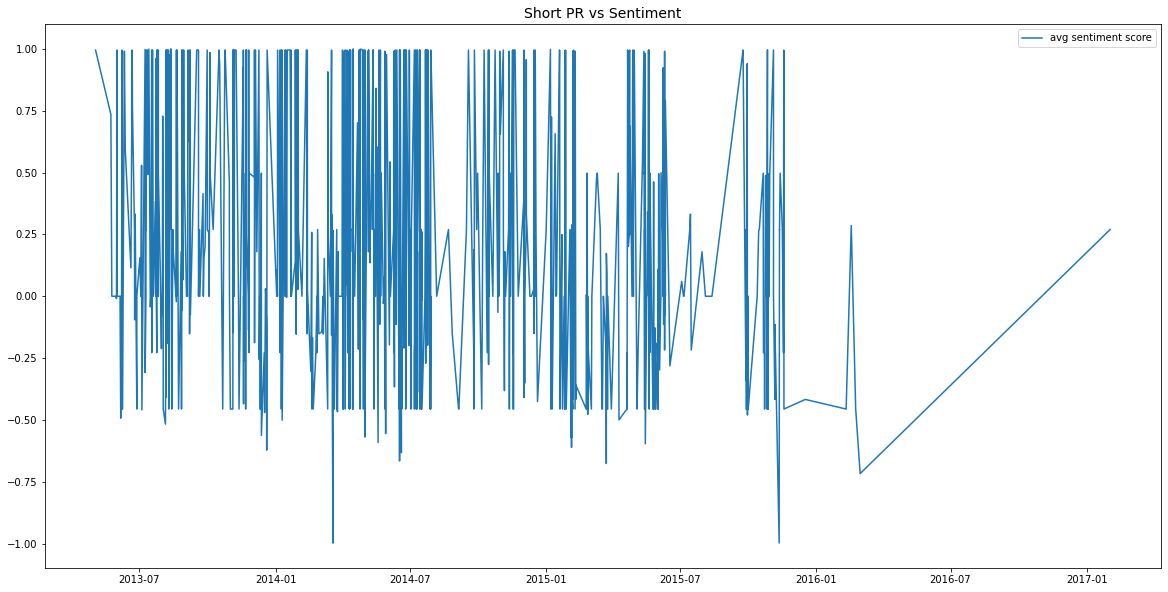

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title('Short PR vs Sentiment', fontsize=14)
plt.scatter(df_short_pr['pr_created_at'], df_short_pr['avg_msg_senti'])
plt.legend(['avg sentiment score'], loc='upper right')

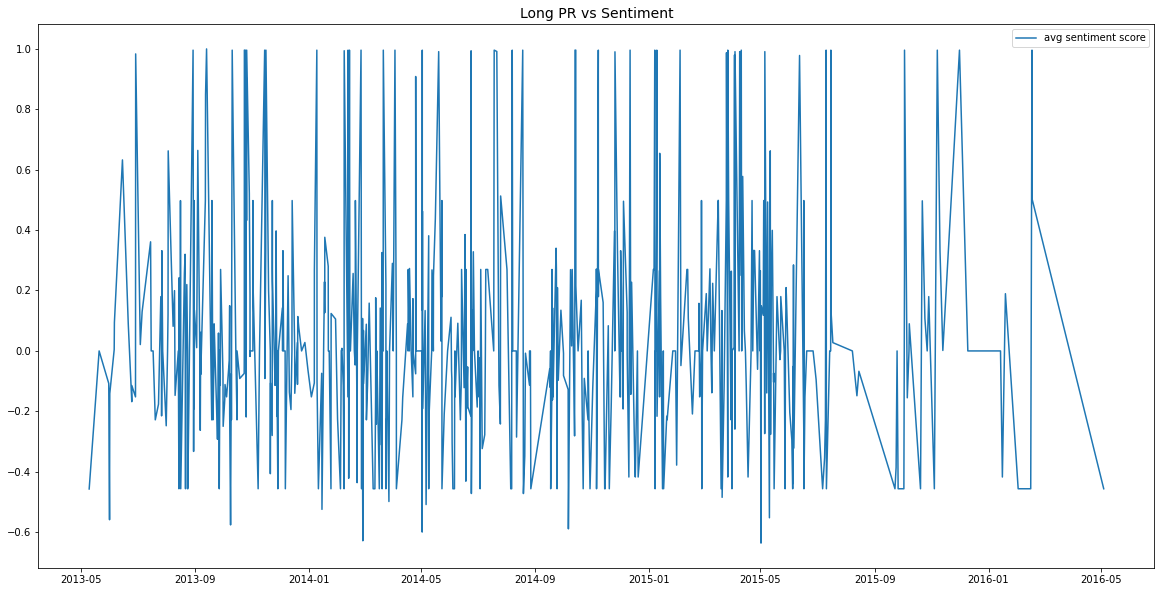

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title('Long PR vs Sentiment', fontsize=14)
plt.scatter(df_long_pr['pr_created_at'], df_long_pr['avg_msg_senti'])
plt.legend(['avg sentiment score'], loc='upper right')

In [ ]:
df_short_pr.to_csv(f'short_pr_{repo_id}.csv', index=False)
df_long_pr.to_csv(f'long_pr_{repo_id}.csv', index=False)